# Vascular, Extracellular and Restricted Diffusion for Cytometry in Tumors (VERDICT)

Reference: Panagiotaki, Eletheria, et al. "Noninvasive quantification of solid tumor microstructure using VERDICT MRI." Cancer research 74.7 (2014): 1902-1912.

In [1]:
from mipy.data.saved_data import DATA_PATH
import numpy as np
import zipfile, urllib2

%cd $DATA_PATH

url = "http://camino.cs.ucl.ac.uk/uploads/Tutorials/"
filename = "LSDTIDWtut.Bfloat.zip"
schemename = "VC_DTIDW.scheme.zip"

downloaded = urllib2.urlopen(url + filename)
with open(filename, 'wb') as f:
    f.write(downloaded.read())
with zipfile.ZipFile(filename) as zip:
    zip.extract('LSDTIDWtut.Bfloat')
    
downloaded = urllib2.urlopen(url + schemename)
with open(schemename, 'wb') as f:
    f.write(downloaded.read())
with zipfile.ZipFile(schemename) as zip:
    zip.extract('VC_DTIDW.scheme')
    
data = np.fromfile(DATA_PATH + "LSDTIDWtut.Bfloat", dtype='>f')
schemefile = np.loadtxt(DATA_PATH + "VC_DTIDW.scheme", skiprows=1)


/home/rfick/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/data


In [2]:
gradient_directions = schemefile[:, :3]
gradient_directions[np.linalg.norm(gradient_directions, axis=1)==0.] = [1., 0., 0.]
gradient_strength = schemefile[:, 3]
Delta =schemefile[:, 4]
delta =schemefile[:, 5]
TE =schemefile[:, 6]

In [3]:
from mipy.core.acquisition_scheme import acquisition_scheme_from_gradient_strengths

In [4]:
scheme = acquisition_scheme_from_gradient_strengths(
    gradient_strength, gradient_directions, delta, Delta, TE, min_b_shell_distance=5)

In [5]:
from mipy.signal_models import sphere_models, cylinder_models, gaussian_models
from mipy.core.modeling_framework import MultiCompartmentModel
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
sphere = sphere_models.S4SphereGaussianPhaseApproximation(
    diffusion_constant=0.9e-9)
ball = gaussian_models.G3Ball()
stick = cylinder_models.C1Stick()
stick._parameter_ranges['lambda_par'] = (3.05, 10)
verdict_mod = MultiCompartmentModel(scheme, models=[sphere, ball, stick])

verdict_mod.optimized_parameters['G3Ball_1_lambda_iso'] = False

initial_guess = verdict_mod.parameter_initial_guess_to_parameter_vector(
    G3Ball_1_lambda_iso = 0.9e-9)

G3Ball_1_lambda_iso successfully set.


In [14]:
verdict_fit = verdict_mod.fit(np.atleast_2d(data), parameter_initial_guess=initial_guess,
                              solver='mix', use_parallel_processing=False)

Starting fitting process
Fitting of 1 voxels complete in 11.7959911823 seconds.
Average of 11.7959911823 seconds per voxel.


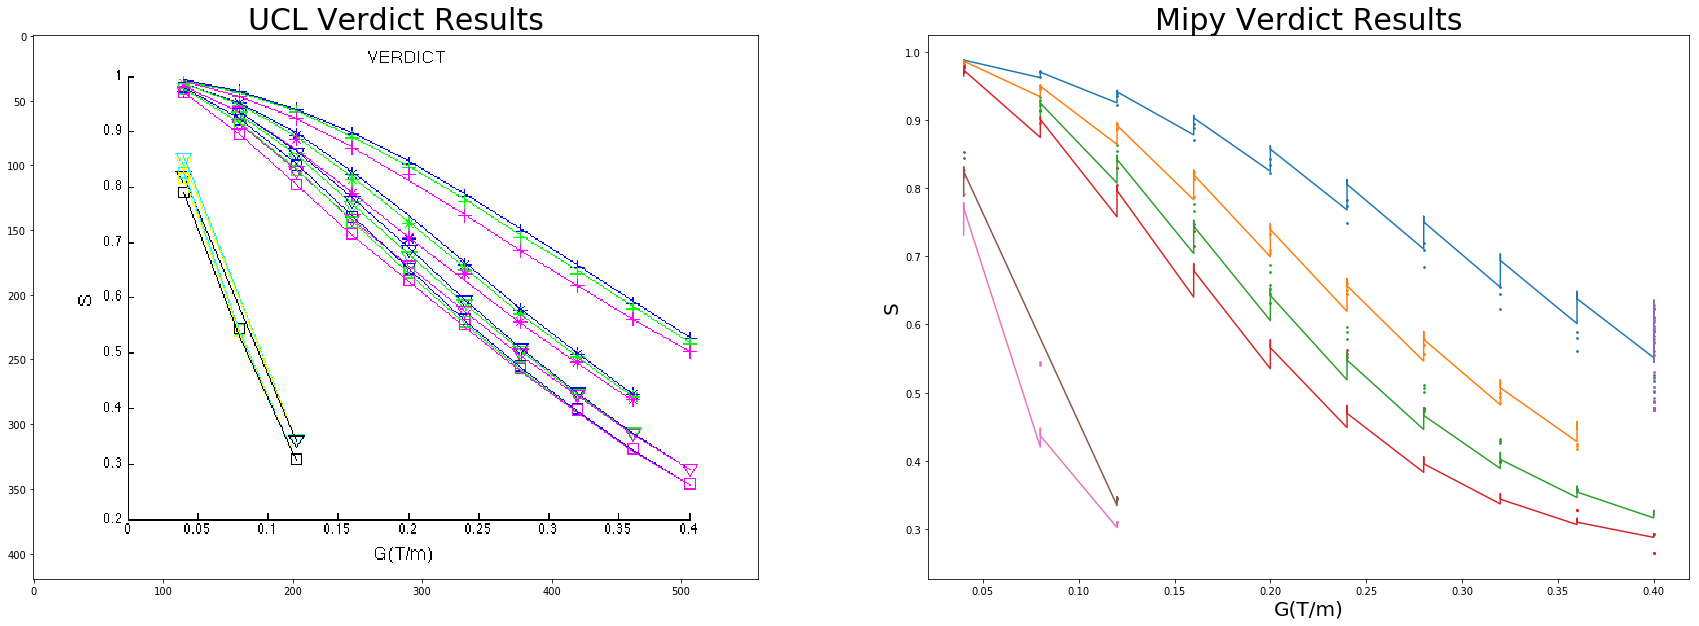

In [15]:
import matplotlib.image as mpimg
img=mpimg.imread("http://camino.cs.ucl.ac.uk/uploads/Tutorials/VCLSsynth.png")
    
mask_nonzero = scheme.gradient_strengths>0.
G_nonzero = scheme.gradient_strengths[mask_nonzero]
Delta_nonzero = scheme.Delta[mask_nonzero]
delta_nonzero = scheme.delta[mask_nonzero]

predicted_data = verdict_fit.predict()[0]
predicted_data_nonzero = predicted_data[mask_nonzero]
data_nonzero = data[mask_nonzero]

fig, axs = plt.subplots(1, 2, figsize=[30, 10])
axs = axs.ravel()
axs[0].imshow(img)
axs[0].set_title('UCL Verdict Results', fontsize=30)

for delta_, Delta_ in np.unique(np.c_[scheme.shell_delta, scheme.shell_Delta], axis=0):
    mask = np.all([Delta_nonzero == Delta_, delta_nonzero == delta_], axis=0)
    axs[1].plot(G_nonzero[mask], predicted_data_nonzero[mask])
    axs[1].scatter(G_nonzero[mask], data_nonzero[mask], s=3.)
axs[1].set_title('Mipy Verdict Results', fontsize=30)
axs[1].set_xlabel('G(T/m)', fontsize=20)
axs[1].set_ylabel('S', fontsize=20);

Not as good results as UCL yet.. possible bug in sphere model.